<a href="https://colab.research.google.com/github/ColeBromfield01/bromfield-portfolio/blob/main/DATA612_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cole Bromfield Homework 1 (DATA612)

## Step 1: Dataset and Neural Network Selection

Device Initialization

In [1]:
import torch

device = torch.device("cpu")
print(f'Using device: {device}')

Using device: cpu


Importing FashionMNIST data

In [2]:
import torchvision
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)

# Define train and test data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


100%|██████████| 26421880/26421880 [00:01<00:00, 18301511.20it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306126.70it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5409516.04it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13279383.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Initializing LeNet-5 neural network, a classic CNN tailored specifically to grayscale image recognition.

In [3]:
import torch.nn as nn


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjusted input size based on conv2 output
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.avgpool1(torch.relu(self.conv1(x)))
        x = self.avgpool2(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor before FC layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initiate the model
model = LeNet5().to(device)


Define loss function and optimizer

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


Training the model

In [5]:
# Number of epochs for training
num_epochs = 5

# Training loop
model.train()
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print statistics every 1000 mini-batches
    running_loss += loss.item()
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader):.3f}')

print('Finished Training')


Epoch [1/5], Loss: 0.770
Epoch [2/5], Loss: 0.517
Epoch [3/5], Loss: 0.441
Epoch [4/5], Loss: 0.399
Epoch [5/5], Loss: 0.369
Finished Training


Confirming accuracy

In [6]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test data: {(100 * correct / total):.2f}%')

Accuracy on test data: 85.60%


## Step 2: Feature Extraction

In [7]:
from torchvision import datasets
import numpy as np

# Function to extract the first convolutional layer
def extract_features(model, dataloader, layer_name='conv1'):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            outputs = model(images)
            activation = model.conv1(images)
            features.append(activation.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features from the trained model
features, labels = extract_features(model, testloader)

# Flatten the features
features = features.reshape(features.shape[0], -1)


## Step 3: TSNE Extracted Feature Visualization

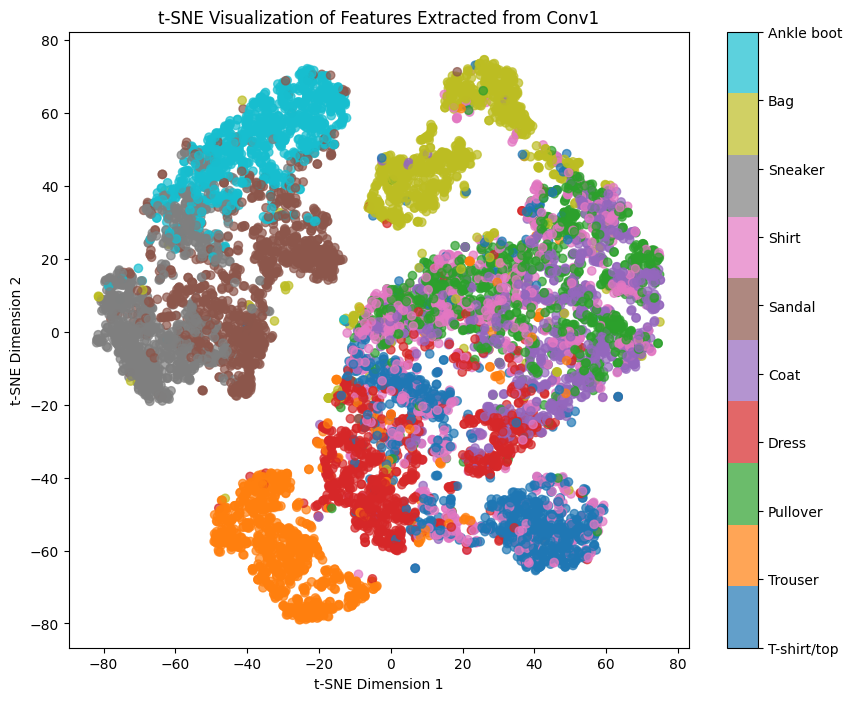

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE reduction
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Visualization
plt.figure(figsize=(10, 8))

# Scatter plot with class labels
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)

# Create a color bar with class names
cbar = plt.colorbar(scatter, ticks=range(len(classes)))
cbar.set_ticklabels(classes)

# Add titles and labels
plt.title('t-SNE Visualization of Features Extracted from Conv1')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()



## Step 4: Inter-class Variance

In [22]:
intra_class_var = []
inter_class_var = []

# Calculate intra-class variance for each class
for class_idx, class_name in enumerate(classes):
    class_features = features[class_idx]
    intra_var = np.var(class_features, axis=0)
    intra_class_var.append(np.mean(intra_var))

# Calculate overall mean of all features
overall_mean = np.mean(features, axis=0)

# Calculate inter-class variance
for class_idx, class_name in enumerate(classes):
    class_features = features[class_idx]
    inter_var = np.var(class_features - overall_mean, axis=0)
    inter_class_var.append(np.mean(inter_var))

# Print the intra-class variance for each class with class names
for class_name, var in zip(classes, intra_class_var):
    print(f'Intra-class Variance for {class_name}: {var:.4f}')

# Print the overall inter-class variance
average_inter_class_var = np.mean(inter_class_var)
print(f'Overall Inter-class Variance: {average_inter_class_var:.4f}')


Intra-class Variance for T-shirt/top: 1.9047
Intra-class Variance for Trouser: 2.5432
Intra-class Variance for Pullover: 3.0871
Intra-class Variance for Dress: 2.4395
Intra-class Variance for Coat: 0.8053
Intra-class Variance for Sandal: 2.5175
Intra-class Variance for Shirt: 1.9597
Intra-class Variance for Sneaker: 1.0541
Intra-class Variance for Bag: 2.5393
Intra-class Variance for Ankle boot: 2.0593
Overall Inter-class Variance: 1.3338


## Step 5: Write-up

*Selection*

I chose the FashionMNIST dataset purely out of familiarity--this dataset was incorporated into multiple previous projects from past courses.  Thus, I already possessed an understanding of the structure/meaning of the data.  With my choice of dataset in mind, I then had to find the optimal classic CNN to employ.  I went with LeNet-5, a CNN specifically designed for black-and-white image classification, allowing for seamless use in conjunction with FashionMNIST.

*Feature Extraction*

I chose to extract the first convolution layer.  Since this layer maintains some of the structure of the initial data, interpretability is still at a relatively high level.  A later convolution layer could prove confusing to the user.

*Observations*

Within the first convolutional layer, certain classes have higher variances than others.  Interestingly, "coat" and "pullover" received radically different variances (one being the highest variance of any class, and the other being the lowest) despite being similar products.

In the visualization, the classes tended to form logical, distinct clusters.  The footwear classes ("ankle boot", "sneaker", and "sandal") were almost entirely separable from the rest, with few exceptions.  "Trouser" and "bag" (each unique items not similar to any other items featured in the dataset) each had very little overlap with other classes.  As the one exception to the distinct clustering pattern, "shirt", "pullover", and "coat" had significant overlap amongst themselves.  This is to be expected, with all three taking a similar shape and size.

*Problems Overcome*

I first attempted to use ResNet, but ran into the issue of channel count mismatch.  Rather than repeating the one channel into a three-channel image, I opted for a model into which the FashionMNIST data would more seamlessly fit.  Additionally, training the ResNet model took a VERY long time--this was not the case with the LeNet-5 model.

The data structure had to be perfected as well, as flattening of the input/output data was necessary to avoid exceptions being thrown.